<h1>Variable declaration</h1>

In [1]:
run_time = [0, 0, 0, 0, 0] # in the order of RRT, RRT*, EERT, A*, Improved A*
expanded_nodes = [0, 0, 0, 0, 0]
path_length = [0, 0, 0, 0, 0]
start_x = [-1,-10]
start_y = [-4,-10]
goal_x = [-12,5]
goal_y = [-2,-5]

<h1>RRT</h1>

In [2]:
## self written rrt

import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy
from rrt_utils import draw_cov, bhattacharyya_distance
import time

image_counter = 1

cov_obs = np.array([[0.001,-0.000],[-0.000,0.015]])
cov_rob = np.array([[0.0001,-0.000],[-0.000,0.0015]])

move_obs = [0.2,0]

show_animation = False


class Node():

	def __init__(self,x,y):

		self.x = x
		self.y = y
		self.parent = None


class RRT():

	def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.0,goal_sample_rate=20, max_iter=500):

		self.start = Node(start[0], start[1])
		self.end = Node(goal[0], goal[1])
		self.minrand = rand_area[0]
		self.maxrand = rand_area[1]
		self.expand_dis = expand_dis
		self.goal_sample_rate = goal_sample_rate
		self.max_iter = max_iter
		self.obstacle_list = obstacle_list

	def Planning(self, animation=True):

		self.node_list = [self.start]

		while True:

			if random.randint(0,100) > self.goal_sample_rate :
				rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
			else :
				rnd = [self.end.x, self.end.y]

			## find the nearest node out of the random sampled node to the previous node in node_list
			nind = self.get_nearest_list_index(self.node_list, rnd)

			## expand the search tree
			nearest_node = self.node_list[nind]

			theta_to_new_node = math.atan2(rnd[1] - nearest_node.y, rnd[0] - nearest_node.x)

			new_node = copy.deepcopy(nearest_node)
			new_node.x += self.expand_dis*math.cos(theta_to_new_node)
			new_node.y += self.expand_dis*math.sin(theta_to_new_node)
			new_node.parent = nind

			## lets check the sequence length upto this node which will be used to grow the covariance
			sequence = [[new_node.x, new_node.y]]
			last_index = new_node.parent
			while self.node_list[last_index].parent is not None:
				node = self.node_list[last_index]
				sequence.append([node.x, node.y])
				last_index = node.parent
			sequence.append([self.start.x, self.start.y])

			sequence_length = len(sequence)

			## check if the new node is in collision
			if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
				continue

			self.node_list.append(new_node)
			# print(len(self.node_list))

			#$ check if goal as at the next node
			dx = new_node.x - self.end.x
			dy = new_node.y - self.end.y
			d = math.sqrt(dx**2 + dy**2)

			if d <= self.expand_dis:
				print("Goal!")
				break

			if animation:
				self.draw_graph(sequence_length, rnd)

		path = [[self.end.x, self.end.y]]
		last_index = len(self.node_list) - 1
		while self.node_list[last_index].parent is not None:
			node = self.node_list[last_index]
			path.append([node.x, node.y])
			last_index = node.parent
		path.append([self.start.x, self.start.y])

		nodelist = self.node_list

		return path, nodelist

	def get_nearest_list_index(self, node_list, rnd):

		distance_list = [(node.x - rnd[0])**2 + (node.y - rnd[1])**2 for node in node_list]
		minind = distance_list.index(min(distance_list))
		return minind



	def __collision_check(self, node, obstacle_list, sequence_length):


		for (ox, oy, size) in obstacle_list:
			ox += sequence_length*move_obs[0]
			oy += sequence_length*move_obs[1]
			dx = ox - node.x
			dy = oy - node.y
			d = math.sqrt(dx**2 + dy**2)
			x_o  = np.array([ox,oy])
			x_r = np.array([node.x,node.y])
			cov_robo = sequence_length*cov_rob
			bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
			# print(d, bhatta_dist)
			if np.abs(bhatta_dist) <= 100:
				return False
		return True

	def draw_graph(self, sequence_length=0, rnd=None):

		global image_counter

		# plt.clf()
		# if rnd is not None:
		# 	plt.plot(rnd[0], rnd[1],'^k')
		# 	x_r = np.array([rnd[0],rnd[1]])
		# 	cov_robo = sequence_length*cov_rob
		# 	xr,yr = draw_cov(x_r, cov_robo, p=0.95)
		# 	plt.plot(xr,yr,'-r')
		# 	# time.sleep(2)

		for node in self.node_list:
			if node.parent is not None:
				plt.plot([node.x, self.node_list[node.parent].x], [node.y, self.node_list[node.parent].y], "-g")
		for (ox, oy, size) in self.obstacle_list:
			ox += sequence_length*move_obs[0]
			oy += sequence_length*move_obs[1]
			x_o = np.array([ox,oy])
			x,y = draw_cov(x_o, cov_obs, p=0.95)
			# plt.plot(x,y,'-b')
			plt.plot(ox, oy, "s", color='black', markersize=size*30)


		plt.plot(self.start.x, self.start.y, "xr")
		plt.plot(self.end.x, self.end.y, "xr")
		plt.axis([-15, 15, -15, 15])
		plt.grid(True)
		# plt.savefig('image%04d'%image_counter)
		image_counter += 1
		plt.pause(0.01)


def main():
	#print("start " + __file__)
	

	global image_counter

	obstacleList = [
		(5, 5, 0.25),
		(3, 6, 0.5),
		(3, 8, 0.5),
		(3, 10, 0.5),
		(7, 5, 0.5),
		(9, 5, 0.5),
		(-10, 10, 0.5),
		(-7, 5, 0.5),
		(-9, -5, 0.5),
		(-10, -4, 0.5),
		(-6, 7, 0.5),
		(-11, 9, 0.5),
		(10, -4, 0.5),
		(6, -10, 0.5),
		(11, -9, 0.5),
		(0, 0, 0.5),
		(-7, 0, 0.5)]

	# Set Initial parameters
	run_times_rrt = []
	path_lengths_rrt = []
	expanded_nodes_rrt = []
	global start_x, start_y, goal_x, goal_y
	for i in range(len(start_x)):
		start_time = time.time()
		rrt = RRT(start=[start_x[i], start_y[i]], goal=[goal_x[i], goal_y[i]],rand_area=[-15, 15], obstacle_list=obstacleList)
		path, node_list = rrt.Planning(animation=show_animation)
		end_time = time.time()
		run_times_rrt.append(end_time - start_time)
		path_lengths_rrt.append(len(path))
		expanded_nodes_rrt.append(len(node_list))
		# Draw final path
		if show_animation:  # pragma: no cover
			# rrt.draw_graph()
			length_path = len(path)
			path = path[::-1]
			# print(path.shape)

			i = 1
			for (x,y) in path:

				plt.clf()

				for node in node_list:
					if node.parent is not None:
						plt.plot([node.x, node_list[node.parent].x], [node.y, node_list[node.parent].y], "-g")

				x_f = np.array([x,y])
				cov_robo = cov_rob*(i-1)
				xf,yf = draw_cov(x_f, cov_robo, p=0.95)
				plt.plot(xf,yf,'--m')
				plt.plot([x for (x, y) in path[0:i+1]], [y for (x, y) in path[0:i+1]], '-r')

				for (ox, oy, size) in obstacleList:
					ox += i*move_obs[0]
					oy += i*move_obs[1]
					x_o = np.array([ox,oy])
					x,y = draw_cov(x_o, cov_obs, p=0.95)
					# plt.plot(x,y,'-b')
					plt.plot(ox, oy, "s", color='black', markersize=size*30)

				plt.grid(True)
				plt.axis([-15, 15, -15, 15])
				plt.plot(-10, -10, "xr")
				plt.plot(gx, gy, "xr")
				plt.pause(0.5)
				# plt.savefig('image%04d'%image_counter)
				image_counter += 1
				i = i + 1
	global run_time, expanded_nodes, path_length
	run_time[0] = math.avg(run_times_rrt)
	expanded_nodes[0] = math.avg(expanded_nodes_rrt)
	path_length[0] = math.avg(path_lengths_rrt)


if __name__ == '__main__':
	main()


NameError: name 'start_x' is not defined

<h1>RRT*</h1>

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy

image_counter = 1

cov_obs = np.array([[0.001,-0.000],[-0.000,0.015]])
cov_rob = np.array([[0.0001,-0.000],[-0.000,0.0015]])

move_obs = [0.2,0]

show_animation = False

class Node():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None

class RRT():
    def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.0, goal_sample_rate=20, max_iter=500, radius=2.0):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.minrand = rand_area[0]
        self.maxrand = rand_area[1]
        self.expand_dis = expand_dis
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.radius = radius
        self.node_list = [self.start]

    def Planning(self, animation=True):
        while True:
            if random.randint(0, 100) > self.goal_sample_rate:
                rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
            else:
                rnd = [self.end.x, self.end.y]

            nind = self.get_nearest_list_index(self.node_list, rnd)
            nearest_node = self.node_list[nind]
            theta_to_new_node = math.atan2(rnd[1] - nearest_node.y, rnd[0] - nearest_node.x)
            new_node = copy.deepcopy(nearest_node)
            new_node.x += self.expand_dis * math.cos(theta_to_new_node)
            new_node.y += self.expand_dis * math.sin(theta_to_new_node)
            new_node.parent = nind

            sequence = [[new_node.x, new_node.y]]
            last_index = new_node.parent
            while self.node_list[last_index].parent is not None:
                node = self.node_list[last_index]
                sequence.append([node.x, node.y])
                last_index = node.parent
            sequence.append([self.start.x, self.start.y])
            sequence_length = len(sequence)

            if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
                continue

            self.node_list.append(new_node)

            dx = new_node.x - self.end.x
            dy = new_node.y - self.end.y
            d = math.sqrt(dx ** 2 + dy ** 2)

            if d <= self.expand_dis:
                break

            near_indices = self.find_near_nodes(new_node)
            for near_index in near_indices:
                near_node = self.node_list[near_index]
                tentative_cost = self.calculate_cost(near_node) + self.distance(near_node, new_node)

                if tentative_cost < self.calculate_cost(new_node):
                    new_node.parent = near_index

            if animation:
                self.draw_graph(sequence_length, rnd)

        path = [[self.end.x, self.end.y]]
        last_index = len(self.node_list) - 1
        while self.node_list[last_index].parent is not None:
            node = self.node_list[last_index]
            path.append([node.x, node.y])
            last_index = node.parent
        path.append([self.start.x, self.start.y])

        nodelist = self.node_list

        return path, nodelist

    def find_near_nodes(self, node):
        near_indices = []
        for idx, existing_node in enumerate(self.node_list):
            if self.distance(existing_node, node) < self.radius:
                near_indices.append(idx)
        return near_indices

    def distance(self, node1, node2):
        return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)

    def calculate_cost(self, node):
        cost = 0
        while node.parent is not None:
            parent_node = self.node_list[node.parent]
            cost += self.distance(node, parent_node)
            node = parent_node
        return cost

    def get_nearest_list_index(self, node_list, rnd):
        distance_list = [(node.x - rnd[0]) ** 2 + (node.y - rnd[1]) ** 2 for node in node_list]
        minind = distance_list.index(min(distance_list))
        return minind

    def __collision_check(self, node, obstacle_list, sequence_length):
        for (ox, oy, size) in obstacle_list:
            ox += sequence_length * move_obs[0]
            oy += sequence_length * move_obs[1]
            dx = ox - node.x
            dy = oy - node.y
            d = math.sqrt(dx ** 2 + dy ** 2)
            x_o = np.array([ox, oy])
            x_r = np.array([node.x, node.y])
            cov_robo = sequence_length * cov_rob
            bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
            # print(d, bhatta_dist)
            if np.abs(bhatta_dist) <= 100:
                return False
        return True

    def draw_graph(self, sequence_length=0, rnd=None):
        global image_counter

        # plt.clf()
        # if rnd is not None:
        # 	plt.plot(rnd[0], rnd[1],'^k')
        # 	x_r = np.array([rnd[0],rnd[1]])
        # 	cov_robo = sequence_length*cov_rob
        # 	xr,yr = draw_cov(x_r, cov_robo, p=0.95)
        # 	plt.plot(xr,yr,'-r')
        # 	# time.sleep(2)

        for node in self.node_list:
          if node.parent is not None:
            plt.plot([node.x, self.node_list[node.parent].x], [node.y, self.node_list[node.parent].y], "-g")
        for (ox, oy, size) in self.obstacle_list:
          ox += sequence_length*move_obs[0]
          oy += sequence_length*move_obs[1]
          x_o = np.array([ox,oy])
          x,y = draw_cov(x_o, cov_obs, p=0.95)
          # plt.plot(x,y,'-b')
          plt.plot(ox, oy, "s", color='black', markersize=size*30)


        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([-15, 15, -15, 15])
        plt.grid(True)
        plt.savefig('image%04d'%image_counter)
        image_counter += 1
        plt.pause(0.01)


def main(gx=6.0, gy=12.0):
    obstacleList = [
        (5, 5, 0.25),
        (5, 5, 0.25),
        (3, 6, 0.5),
        (3, 8, 0.5),
        (3, 10, 0.5),
        (7, 5, 0.5),
        (9, 5, 0.5),
        (-10, 10, 0.5),
        (-7, 5, 0.5),
        (-9, -5, 0.5),
        (-10, -4, 0.5),
        (-6, 7, 0.5),
        (-11, 9, 0.5),
        (10, -4, 0.5),
        (6, -10, 0.5),
        (11, -9, 0.5),
        (0, 0, 0.5),
        (-7, 0, 0.5)
    ]
    start_time = time.time()
    rrt = RRT(start=[-10, -10], goal=[gx, gy],rand_area=[-15, 15], obstacle_list=obstacleList)
    path, node_list = rrt.Planning(animation=show_animation)
    end_time = time.time()
    global run_time, expanded_nodes, path_length
    run_time[1] = end_time - start_time
    expanded_nodes[1] = len(node_list)
    path_length[1] = len(path)
    	# Draw final path
    if show_animation:  # pragma: no cover
      # rrt.draw_graph()
      length_path = len(path)
      path = path[::-1]
      # print(path.shape)

      i = 1
      for (x,y) in path:

        plt.clf()

        for node in node_list:
          if node.parent is not None:
            plt.plot([node.x, node_list[node.parent].x], [node.y, node_list[node.parent].y], "-g")

        x_f = np.array([x,y])
        cov_robo = cov_rob*(i-1)
        xf,yf = draw_cov(x_f, cov_robo, p=0.95)
        plt.plot(xf,yf,'--m')
        plt.plot([x for (x, y) in path[0:i+1]], [y for (x, y) in path[0:i+1]], '-r')

        for (ox, oy, size) in obstacleList:
          ox += i*move_obs[0]
          oy += i*move_obs[1]
          x_o = np.array([ox,oy])
          x,y = draw_cov(x_o, cov_obs, p=0.95)
          # plt.plot(x,y,'-b')
          plt.plot(ox, oy, "s", color='black', markersize=size*30)

        plt.grid(True)
        plt.axis([-15, 15, -15, 15])
        plt.plot(-10, -10, "xr")
        plt.plot(gx, gy, "xr")
        plt.pause(0.5)
        # plt.savefig('image%04d'%image_counter)
        # image_counter += 1
        i = i + 1

if __name__ == '__main__':
	main()


<h1>ERRT</h1>

In [5]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy
import time

# Assuming your draw_cov and bhattacharyya_distance functions are defined in rrt_utils module
from rrt_utils import draw_cov, bhattacharyya_distance
image_counter = 1

cov_obs = np.array([[0.001, -0.000], [-0.000, 0.015]])
cov_rob = np.array([[0.0001, -0.000], [-0.000, 0.0015]])
min_distance = 500
move_obs = [0.2, 0]
show_animation = False

class Node():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None

class RRT():
    def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.0, goal_sample_rate=20, max_iter=500, radius=2.0):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.minrand = rand_area[0]
        self.maxrand = rand_area[1]
        self.expand_dis = expand_dis
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.radius = radius
        self.node_list = [self.start]

    def Planning(self, animation=True):
        while True:
            if random.randint(0, 100) > self.goal_sample_rate:
                rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
            else:
                rnd = [self.end.x, self.end.y]

            nind = self.get_nearest_list_index(self.node_list, rnd)
            nearest_node = self.node_list[nind]
            theta_to_new_node = math.atan2(rnd[1] - nearest_node.y, rnd[0] - nearest_node.x)
            new_node = copy.deepcopy(nearest_node)
            new_node.x += self.expand_dis * math.cos(theta_to_new_node)
            new_node.y += self.expand_dis * math.sin(theta_to_new_node)
            new_node.parent = nind
            			
            sequence = [[new_node.x, new_node.y]]
            last_index = new_node.parent
            while self.node_list[last_index].parent is not None:
                node = self.node_list[last_index]
                sequence.append([node.x, node.y])
                last_index = node.parent
            sequence.append([self.start.x, self.start.y])
            sequence_length = len(sequence)

            if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
                continue

            global min_distance
            if self.distance(new_node, self.end) > min_distance:
                continue
            
            min_distance = min(min_distance, self.distance(new_node, self.end))
            self.node_list.append(new_node)

            dx = new_node.x - self.end.x
            dy = new_node.y - self.end.y
            d = math.sqrt(dx ** 2 + dy ** 2)

            if d <= self.expand_dis:
                break

            near_indices = self.find_near_nodes(new_node)
            for near_index in near_indices:
                near_node = self.node_list[near_index]
                tentative_cost = self.calculate_cost(near_node) + self.distance(near_node, new_node)

                if tentative_cost < self.calculate_cost(new_node):
                    new_node.parent = near_index

            if animation:
                self.draw_graph(sequence_length, rnd)

        path = [[self.end.x, self.end.y]]
        last_index = len(self.node_list) - 1
        while self.node_list[last_index].parent is not None:
            node = self.node_list[last_index]
            path.append([node.x, node.y])
            last_index = node.parent
        path.append([self.start.x, self.start.y])

        nodelist = self.node_list

        return path, nodelist

    def find_near_nodes(self, node):
        near_indices = []
        for idx, existing_node in enumerate(self.node_list):
            if self.distance(existing_node, node) < self.radius:
                near_indices.append(idx)
        return near_indices

    def distance(self, node1, node2):
        return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)

    def calculate_cost(self, node):
        cost = 0
        while node.parent is not None:
            parent_node = self.node_list[node.parent]
            cost += self.distance(node, parent_node)
            node = parent_node
        return cost

    def get_nearest_list_index(self, node_list, rnd):
        distance_list = [(node.x - rnd[0]) ** 2 + (node.y - rnd[1]) ** 2 for node in node_list]
        minind = distance_list.index(min(distance_list))
        return minind

    def __collision_check(self, node, obstacle_list, sequence_length):
        for (ox, oy, size) in obstacle_list:
            ox += sequence_length * move_obs[0]
            oy += sequence_length * move_obs[1]
            dx = ox - node.x
            dy = oy - node.y
            d = math.sqrt(dx ** 2 + dy ** 2)
            x_o = np.array([ox, oy])
            x_r = np.array([node.x, node.y])
            cov_robo = sequence_length * cov_rob
            bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
            # print(d, bhatta_dist)
            if np.abs(bhatta_dist) <= 100:
                return False
        return True

    def draw_graph(self, sequence_length=0, rnd=None):
        global image_counter

        # plt.clf()
        # if rnd is not None:
        # 	plt.plot(rnd[0], rnd[1],'^k')
        # 	x_r = np.array([rnd[0],rnd[1]])
        # 	cov_robo = sequence_length*cov_rob
        # 	xr,yr = draw_cov(x_r, cov_robo, p=0.95)
        # 	plt.plot(xr,yr,'-r')
        # 	# time.sleep(2)

        for node in self.node_list:
          if node.parent is not None:
            plt.plot([node.x, self.node_list[node.parent].x], [node.y, self.node_list[node.parent].y], "-g")
        for (ox, oy, size) in self.obstacle_list:
          ox += sequence_length*move_obs[0]
          oy += sequence_length*move_obs[1]
          x_o = np.array([ox,oy])
          x,y = draw_cov(x_o, cov_obs, p=0.95)
          # plt.plot(x,y,'-b')
          plt.plot(ox, oy, "s", color='black', markersize=size*30)


        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([-15, 15, -15, 15])
        plt.grid(True)
        plt.savefig('image%04d'%image_counter)
        image_counter += 1
        plt.pause(0.01)


def main(gx=6.0, gy=12.0):
    obstacleList = [
        (5, 5, 0.25),
        (5, 5, 0.25),
        (3, 6, 0.5),
        (3, 8, 0.5),
        (3, 10, 0.5),
        (7, 5, 0.5),
        (9, 5, 0.5),
        (-10, 10, 0.5),
        (-7, 5, 0.5),
        (-9, -5, 0.5),
        (-10, -4, 0.5),
        (-6, 7, 0.5),
        (-11, 9, 0.5),
        (10, -4, 0.5),
        (6, -10, 0.5),
        (11, -9, 0.5),
        (0, 0, 0.5),
        (-7, 0, 0.5)
    ]
    global run_time, expanded_nodes, path_length
    start_time = time.time()
    rrt = RRT(start=[-10, -10], goal=[gx, gy], rand_area=[-15, 15], obstacle_list=obstacleList)
    path, node_list = rrt.Planning(animation=show_animation)
    end_time = time.time()

    run_time[2] = end_time - start_time
    expanded_nodes[2] = len(node_list)
    path_length[2] = len(path)

    	# Draw final path
    if show_animation:  # pragma: no cover
      # rrt.draw_graph()
      length_path = len(path)
      path = path[::-1]
      # print(path.shape)

      i = 1
      for (x,y) in path:

        plt.clf()

        for node in node_list:
          if node.parent is not None:
            plt.plot([node.x, node_list[node.parent].x], [node.y, node_list[node.parent].y], "-g")

        x_f = np.array([x,y])
        cov_robo = cov_rob*(i-1)
        xf,yf = draw_cov(x_f, cov_robo, p=0.95)
        plt.plot(xf,yf,'--m')
        plt.plot([x for (x, y) in path[0:i+1]], [y for (x, y) in path[0:i+1]], '-r')

        for (ox, oy, size) in obstacleList:
          ox += i*move_obs[0]
          oy += i*move_obs[1]
          x_o = np.array([ox,oy])
          x,y = draw_cov(x_o, cov_obs, p=0.95)
          # plt.plot(x,y,'-b')
          plt.plot(ox, oy, "s", color='black', markersize=size*30)

        plt.grid(True)
        plt.axis([-15, 15, -15, 15])
        plt.plot(-10, -10, "xr")
        plt.plot(gx, gy, "xr")
        plt.pause(0.5)
        # plt.savefig('image%04d'%image_counter)
        # image_counter += 1
        i = i + 1

if __name__ == '__main__':
	main()


<h1>A*</h1>

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy
from rrt_utils import draw_cov, bhattacharyya_distance
import heapq
import time

image_counter = 1

cov_obs = np.array([[0.001, -0.000], [-0.000, 0.015]])
cov_rob = np.array([[0.0001, -0.000], [-0.000, 0.0015]])

move_obs = [0.2, 0]

show_animation = False

class Node():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.g = 0  # Cost to reach this node from the start
        self.h = 0  # Estimated cost to reach the goal from this node
    
    def __lt__(self, other):
        # Define the custom comparison for the heap based on the 'first' attribute
        return self.g + self.h < other.h +other.g 

class RRT():
    def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=2.0, goal_sample_rate=1, max_iter=500):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.minrand = rand_area[0]
        self.maxrand = rand_area[1]
        self.expand_dis = expand_dis
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = [self.start]  # Initialize node_list as an empty list

    def Astar(self, animation=True):
        open_set = []
        heapq.heappush(open_set, self.start)  # Add the start node to open_set
        closed_set = set()  # Set to store explored nodes
        # path = [[self.start.x,self.start.y]]
        # sequence_length = 0
        while open_set:
            current_node = heapq.heappop(open_set)
            # current_node = currTemp.y
            if self.distance(current_node ,self.end) < 0.25:
                print("Goal!")
                path = []
                while current_node:
                    path.append([current_node.x, current_node.y])
                    current_node = current_node.parent
                path.reverse()
                return path

            closed_set.add(current_node)

            # Generate neighboring nodes
            for _ in range(10):  # Sample random nodes multiple times for exploration
                if random.randint(0, 100) > self.goal_sample_rate:
                    rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
                else:
                    rnd = [self.end.x, self.end.y]
                
                sequence = []  # Sequence of positions for collision checking
                last_index = self.get_nearest_list_index(self.node_list, rnd)  # Get nearest node index
                while last_index is not None:
                    node = self.node_list[last_index]
                    sequence.append([node.x, node.y])
                    last_index = self.get_node_index(self.node_list,node.parent)

                theta_to_new_node = math.atan2(rnd[1] - current_node.y, rnd[0] - current_node.x)
                new_x = current_node.x + self.expand_dis * math.cos(theta_to_new_node)
                new_y = current_node.y + self.expand_dis * math.sin(theta_to_new_node)

                new_node = Node(new_x, new_y)
                new_node.parent = current_node
                new_node.g = current_node.g + self.expand_dis
                new_node.h = math.sqrt((new_node.x - self.end.x) ** 2 + (new_node.y - self.end.y) ** 2)

                
                
                sequence.append([self.start.x, self.start.y])
                # last_node = current_node
                # while last_node.parent :
                #     node = last_node
                #     sequence.append([node.x, node.y])
                #     last_node= node.parent
                sequence_length = len(sequence)
                # print(sequence_length)
                # print("\n\n")
                if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
                    continue
               
                if self.distance(new_node ,self.end) < 0.25:
                    print("Goal!")
                    path = []
                    while new_node:
                        path.append([new_node.x, new_node.y])
                        new_node = new_node.parent
                    path.reverse()
                    return path
                # path.append(new_node)
                # Add the new node to open_set
                if new_node not in closed_set:
                    heapq.heappush(open_set, new_node)
                    self.node_list.append(new_node)

            if animation:
                # Update the visualization (you can modify this part as needed)
                self.draw_graph(sequence_length,rnd)
        return None  # Failed to find the path
    
    def get_nearest_list_index(self, node_list, rnd):
        distance_list = [math.sqrt((node.x - rnd[0]) ** 2 + (node.y - rnd[1]) ** 2) for node in node_list]
        minind = distance_list.index(min(distance_list))
        return minind
    
    def get_node_index(self,node_list, node_val):

        for i, node in enumerate(node_list) :
            if node_val == node:
                return i
        return None      
      
    def distance(self, node1, node2):
        return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)    
    
    def __collision_check(self, node, obstacle_list, sequence_length):
        for (ox, oy, size) in obstacle_list:
            ox += sequence_length * move_obs[0]
            oy += sequence_length * move_obs[1]
            dx = ox - node.x
            dy = oy - node.y
            d = math.sqrt(dx ** 2 + dy ** 2)
            x_o = np.array([ox, oy])
            x_r = np.array([node.x, node.y])
            cov_robo = sequence_length * cov_rob
            bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
            # print(d, bhatta_dist)
            if np.abs(bhatta_dist) <= 100:
                return False
        return True


    def draw_graph(self, sequence_length, rnd=None):
        global image_counter


        for node in self.node_list:
            if node.parent is not None:
                plt.plot([node.x, self.node_list[self.get_node_index(self.node_list,node.parent)].x], [node.y, self.node_list[self.get_node_index(self.node_list,node.parent)].y], "-g")
        for (ox, oy, size) in self.obstacle_list:
            ox += sequence_length*move_obs[0]
            oy += sequence_length*move_obs[1]
            x_o = np.array([ox,oy])
            x,y = draw_cov(x_o, cov_obs, p=0.95)
            # plt.plot(x,y,'-b')
            plt.plot(ox, oy, "s", color='black', markersize=size*30)


        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([-15, 15, -15, 15])
        plt.grid(True)
        # plt.savefig('image%04d'%image_counter)
        image_counter += 1
        plt.pause(0.01)


def main(gx=6.0, gy=12.0):
    obstacleList = [
    (5, 5, 0.25),
    (3, 6, 0.5),
    (3, 8, 0.5),
    (3, 10, 0.5),
    (7, 5, 0.5),
    (9, 5, 0.5),
    (-10, 10, 0.5),
    (-7, 5, 0.5),
    (-9, -5, 0.5),
    (-10, -4, 0.5),
    (-6, 7, 0.5),
    (-11, 9, 0.5),
    (10, -4, 0.5),
    (6, -10, 0.5),
    (11, -9, 0.5),
    (0, 0, 0.5),
    (-7, 0, 0.5)]

    global run_time, expanded_nodes, path_length
    start_time = time.time()
    rrt = RRT(start=[-10, -10], goal=[gx, gy], rand_area=[-15, 15], obstacle_list=obstacleList)
    path = rrt.Astar(animation=show_animation)
    end_time = time.time()

    run_time[3] = end_time - start_time
    expanded_nodes[3] = len(rrt.node_list)
    path_length[3] = len(path)


    
    
    	# Draw final path
    if show_animation:  # pragma: no cover
      # rrt.draw_graph()
        # length_path = len(path)
        # path = path[::-1]
        # print(path.shape)

        i = 1
        for (x,y) in path:

            plt.clf()

            for node in rrt.node_list:
                if node.parent is not None:
                    plt.plot([node.x, rrt.node_list[rrt.get_node_index(rrt.node_list,node.parent)].x], [node.y, rrt.node_list[rrt.get_node_index(rrt.node_list,node.parent)].y], "-g")

            x_f = np.array([x,y])
            cov_robo = cov_rob*(i-1)
            xf,yf = draw_cov(x_f, cov_robo, p=0.95)
            plt.plot(xf,yf,'--m')
            plt.plot([x for (x, y) in path[0:i+1]], [y for (x, y) in path[0:i+1]], '-r')

            for (ox, oy, size) in obstacleList:
                ox += i*move_obs[0]
                oy += i*move_obs[1]
                x_o = np.array([ox,oy])
                x,y = draw_cov(x_o, cov_obs, p=0.95)
                # plt.plot(x,y,'-b')
                plt.plot(ox, oy, "s", color='black', markersize=size*30)

            plt.grid(True)
            plt.axis([-15, 15, -15, 15])
            plt.plot(-10, -10, "xr")
            plt.plot(gx, gy, "xr")
            plt.pause(0.5)
            # plt.savefig('image%04d'%image_counter)
            # image_counter += 1
            i = i + 1

if __name__ == '__main__':
	main()



KeyboardInterrupt: 

<h1>Improved Astar</h1>

In [8]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import copy
from rrt_utils import draw_cov, bhattacharyya_distance
import heapq
import time

image_counter = 1

cov_obs = np.array([[0.001, -0.000], [-0.000, 0.015]])
cov_rob = np.array([[0.0001, -0.000], [-0.000, 0.0015]])

move_obs = [0.2, 0]
show_animation = False

class Node():
    def __init__(self, x, y):
        self.x = x
        self.y = y
        self.parent = None
        self.g = 0  # Cost to reach this node from the start
        self.h = 0  # Estimated cost to reach the goal from this node
        self.f = 0  # Total cost of this node: f = g + h + a1_cost + a2_cost + ... + an_cost
    
    def __lt__(self, other):
        # Define the custom comparison for the heap based on the 'first' attribute
        return self.f < other.f

class RRT():
    def __init__(self, start, goal, obstacle_list, rand_area, expand_dis=1.0, goal_sample_rate=50, max_iter=500, water_levels=None):
        self.start = Node(start[0], start[1])
        self.end = Node(goal[0], goal[1])
        self.water_levels = water_levels
        self.minrand = rand_area[0]
        self.maxrand = rand_area[1]
        self.expand_dis = expand_dis
        self.goal_sample_rate = goal_sample_rate
        self.max_iter = max_iter
        self.obstacle_list = obstacle_list
        self.node_list = [self.start]  # Initialize node_list as an empty list

    def Astar(self, animation=True):
        open_set = []
        heapq.heappush(open_set, self.start)  # Add the start node to open_set
        closed_set = set()  # Set to store explored nodes
        
        while open_set:
            current_node = heapq.heappop(open_set)
            
            closed_set.add(current_node)

            # Generate neighboring nodes
            for _ in range(10):  # Sample random nodes multiple times for exploration
                if random.randint(0, 100) > self.goal_sample_rate:
                    rnd = [random.uniform(self.minrand, self.maxrand), random.uniform(self.minrand, self.maxrand)]
                else:
                    rnd = [self.end.x, self.end.y]
                
                sequence = []  # Sequence of positions for collision checking
                last_index = self.get_nearest_list_index(self.node_list, rnd)  # Get nearest node index
                while last_index is not None:
                    node = self.node_list[last_index]
                    sequence.append([node.x, node.y])
                    last_index = self.get_node_index(self.node_list,node.parent)

                theta_to_new_node = math.atan2(rnd[1] - current_node.y, rnd[0] - current_node.x)
                new_x = current_node.x + self.expand_dis * math.cos(theta_to_new_node)
                new_y = current_node.y + self.expand_dis * math.sin(theta_to_new_node)

                new_node = Node(new_x, new_y)
                new_node.parent = current_node
                new_node.g = current_node.g + self.expand_dis
                new_node.h = math.sqrt((new_node.x - self.end.x) ** 2 + (new_node.y - self.end.y) ** 2)
                # additional cost 1
                a1_cost = 0
                
                water_x = math.ceil(new_node.x)
                
                water_y = math.ceil(new_node.y)
                
                if self.water_levels[water_x][water_y] <= 3:
                    a1_cost = 100000/self.water_levels[water_x][water_y]
                else:
                    a1_cost = -10*self.water_levels[water_x][water_y]
                # additional cost 2
                a2_cost = 0
                if self.is_surrounded_by_obstacles(node.x, node.y):
                    a2_cost = new_node.h * 2

                
                new_node.f = new_node.g + new_node.h + a1_cost + a2_cost
                # print(water_x,water_y,self.water_levels[water_x][water_y],new_x,new_y,new_node.f, a1_cost, a2_cost)
                sequence.append([self.start.x, self.start.y])
                
                sequence_length = len(sequence)
                
                if not self.__collision_check(new_node, self.obstacle_list, sequence_length):
                    continue
                
                if self.distance(new_node,self.end) <= 0.25:
                    print("Goal!")
                    path = []
                    while current_node:
                        path.append([current_node.x, current_node.y])
                        current_node = current_node.parent
                    path.reverse()
                    return path
                if new_node not in closed_set and self.water_levels[water_x][water_y] > 3:
                    heapq.heappush(open_set, new_node)
                    self.node_list.append(new_node)
                elif self.water_levels[water_x][water_y] <= 3 and random.randint(0, 100) > 80:
                    heapq.heappush(open_set, new_node)
                    self.node_list.append(new_node)

            if animation:
                # Update the visualization (you can modify this part as needed)
                self.draw_graph(sequence_length,rnd)
        return None  # Failed to find the path
    
    def get_nearest_list_index(self, node_list, rnd):
        distance_list = [math.sqrt((node.x - rnd[0]) ** 2 + (node.y - rnd[1]) ** 2) for node in node_list]
        minind = distance_list.index(min(distance_list))
        return minind
    
    
    def distance(self, node1, node2):
        return math.sqrt((node1.x - node2.x) ** 2 + (node1.y - node2.y) ** 2)    
    

    def get_node_index(self,node_list, node_val):

        for i, node in enumerate(node_list) :
            if node_val == node:
                return i
        return None      
      
    def is_surrounded_by_obstacles(self, x, y):
        # Check if the cell at (x, y) is surrounded by obstacles

        # Define the eight possible neighboring cell offsets (4 cardinal directions and 4 diagonals)
        neighbors = [(1, 0), (-1, 0), (0, 1), (0, -1), (1, 1), (1, -1), (-1, 1), (-1, -1)]

        # Iterate through the neighboring cells and check if they are obstacles
        for dx, dy in neighbors:
            nx, ny = x + dx, y + dy
            if (nx, ny) not in self.obstacle_list:
                # At least one neighboring cell is not an obstacle
                return False

        # All neighboring cells are obstacles
        return True


    def __collision_check(self, node, obstacle_list, sequence_length):
        for (ox, oy, size) in obstacle_list:
            ox += sequence_length * move_obs[0]
            oy += sequence_length * move_obs[1]
            dx = ox - node.x
            dy = oy - node.y
            d = math.sqrt(dx ** 2 + dy ** 2)
            x_o = np.array([ox, oy])
            x_r = np.array([node.x, node.y])
            cov_robo = sequence_length * cov_rob
            bhatta_dist = bhattacharyya_distance(x_r, x_o, cov_robo, cov_obs)
            # print(d, bhatta_dist)
            if np.abs(bhatta_dist) <= 100:
                return False
        return True


    def draw_graph(self, sequence_length, rnd=None):
        global image_counter

        # plt.clf()
        # if rnd is not None:
        # 	plt.plot(rnd[0], rnd[1],'^k')
        # 	x_r = np.array([rnd[0],rnd[1]])
        # 	cov_robo = sequence_length*cov_rob
        # 	xr,yr = draw_cov(x_r, cov_robo, p=0.95)
        # 	plt.plot(xr,yr,'-r')
        # 	# time.sleep(2)

        for node in self.node_list:
            if node.parent is not None:
                plt.plot([node.x, self.node_list[self.get_node_index(self.node_list,node.parent)].x], [node.y, self.node_list[self.get_node_index(self.node_list,node.parent)].y], "-g")
        for (ox, oy, size) in self.obstacle_list:
            ox += sequence_length*move_obs[0]
            oy += sequence_length*move_obs[1]
            x_o = np.array([ox,oy])
            x,y = draw_cov(x_o, cov_obs, p=0.95)
            # plt.plot(x,y,'-b')
            plt.plot(ox, oy, "s", color='black', markersize=size*30)


        plt.plot(self.start.x, self.start.y, "xr")
        plt.plot(self.end.x, self.end.y, "xr")
        plt.axis([-15, 15, -15, 15])
        plt.grid(True)
        # plt.savefig('image%04d'%image_counter)
        image_counter += 1
        plt.pause(0.01)


def main(gx=6.0, gy=12.0):
    obstacleList = [
    (5, 5, 0.25),
    (3, 6, 0.5),
    (3, 8, 0.5),
    (3, 10, 0.5),
    (7, 5, 0.5),
    (9, 5, 0.5),
    (-10, 10, 0.5),
    (-7, 5, 0.5),
    (-9, -5, 0.5),
    (-10, -4, 0.5),
    (-6, 7, 0.5),
    (-11, 9, 0.5),
    (10, -4, 0.5),
    (6, -10, 0.5),
    (11, -9, 0.5),
    (0, 0, 0.5),
    (-7, 0, 0.5)]

    water_levels = [[3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [6,6,6,6,6,6,6,6,6,6,6,6,3,3,3,3,3,3,3,3,6,6,6,6,6,6,6,6,6,6],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,6,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    [3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3,3],
                    ]
    # water_levels = [[3] * 30 for _ in range(30)]
    # for x in range(-10, 7):
    #     for y in range(-10, 13):
    #         water_levels[x][y] = 5

    # Set specific cells to values above 3
    start_time = time.time()
    rrt = RRT(start=[-10, -10], goal=[gx, gy], rand_area=[-15, 15], obstacle_list=obstacleList,water_levels=water_levels)
    path = rrt.Astar(animation=show_animation)

    end_time = time.time()
    global run_time, expanded_nodes, path_length
    run_time[4] = end_time - start_time
    expanded_nodes[4] = len(rrt.node_list)
    path_length[4] = len(path)
    	# Draw final path
    if show_animation:  # pragma: no cover
      # rrt.draw_graph()
        # length_path = len(path)
        # path = path[::-1]
        # print(path.shape)
        rrt.node_list =  list(reversed(rrt.node_list))
        i = 1
        for (x,y) in path:

            plt.clf()
            
            for node in rrt.node_list:
                if node.parent is not None:
                    plt.plot([node.x, rrt.node_list[rrt.get_node_index(rrt.node_list,node.parent)].x], [node.y, rrt.node_list[rrt.get_node_index(rrt.node_list,node.parent)].y], "-g")

            x_f = np.array([x,y])
            cov_robo = cov_rob*(i-1)
            xf,yf = draw_cov(x_f, cov_robo, p=0.95)
            plt.plot(xf,yf,'--m')
            # print(path)
            # path1 = list(reversed(path))
            # print(path1)
            plt.plot([x for (x, y) in (path[0:i+1])], [y for (x, y) in path[0:i+1]], '-r')

            for (ox, oy, size) in obstacleList:
                ox += i*move_obs[0]
                oy += i*move_obs[1]
                x_o = np.array([ox,oy])
                x,y = draw_cov(x_o, cov_obs, p=0.95)
                # plt.plot(x,y,'-b')
                plt.plot(ox, oy, "s", color='black', markersize=size*30)

            plt.grid(True)
            plt.axis([-15, 15, -15, 15])
            plt.plot(-10, -10, "xr")
            plt.plot(gx, gy, "xr")
            plt.pause(0.5)
            # plt.savefig('image%04d'%image_counter)
            # image_counter += 1
            i = i + 1

if __name__ == '__main__':
	main()



Goal!


<h1>Plots</h1>

C:\Users\tumma\AppData\Local\Temp\ipykernel_24296\58973369.py:28: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(algorithms, rotation=15, ha='right')


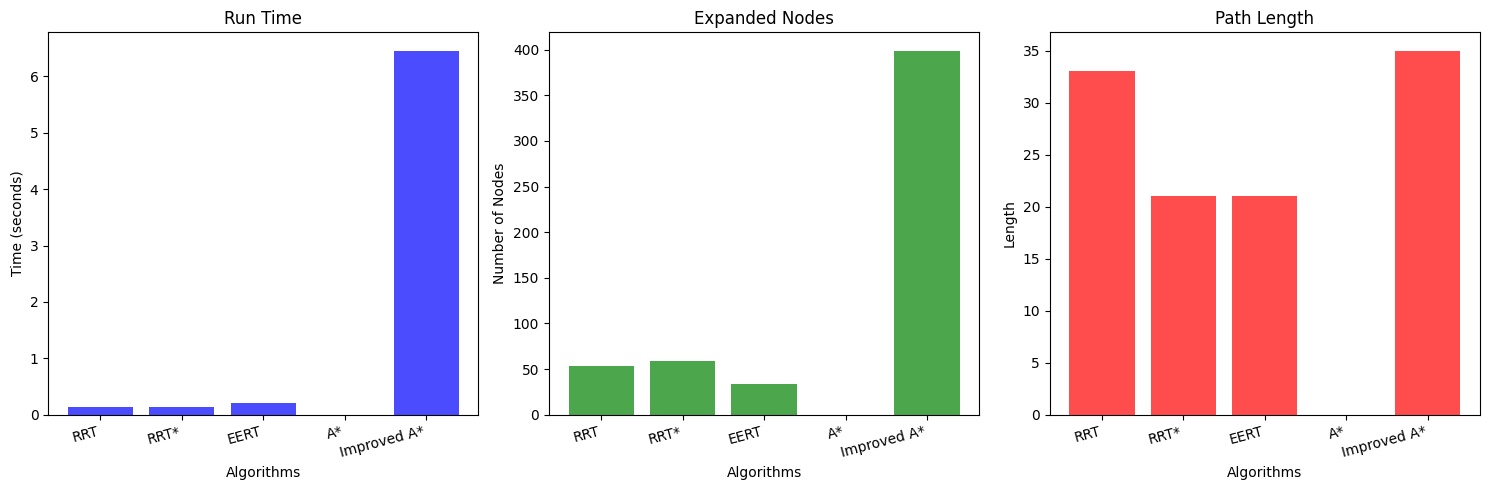

In [9]:
import numpy as np
import matplotlib.pyplot as plt

# Arrays for the data
algorithms = ['RRT', 'RRT*', 'EERT', 'A*', 'Improved A*']

# Create subplots for the three properties
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Plot run_time
axes[0].bar(algorithms, run_time, color='b', alpha=0.7)
axes[0].set_title('Run Time')
axes[0].set_ylabel('Time (seconds)')

# Plot expanded_nodes
axes[1].bar(algorithms, expanded_nodes, color='g', alpha=0.7)
axes[1].set_title('Expanded Nodes')
axes[1].set_ylabel('Number of Nodes')

# Plot path_length
axes[2].bar(algorithms, path_length, color='r', alpha=0.7)
axes[2].set_title('Path Length')
axes[2].set_ylabel('Length')

# Add labels to the x-axis for readability
for ax in axes:
    ax.set_xlabel('Algorithms')
    ax.set_xticklabels(algorithms, rotation=15, ha='right')

plt.tight_layout()
plt.show()